Should be run from inside xCell directory

In [1]:
import numpy as np
import pymaster as nmt
import matplotlib.pyplot as plt
import healpy as hp
import xcell as xc

In [2]:
map_energy = False

1. Read galaxy maps, mask and redshift distributions

In [3]:
nside = 128
galmaps = list([hp.ud_grade(hp.read_map(f'../Galaxy_Maps/map_WIxSCx2M__{i}.fits'),
                                nside_out=nside) for i in range(6)])
[galmaps.append(hp.ud_grade(hp.read_map(f'../Galaxy_Maps_2/map_DELS__{i}_nuX.fits.gz'),
                                nside_out=nside)) for i in range(4)]
[galmaps.append(hp.ud_grade(hp.read_map(f'../Galaxy_Maps_2/map_SDSS__QSO{i}_nuX.fits.gz'),
                                nside_out=nside)) for i in range(2)]
galmaps = np.array(galmaps)
galmask = []
[galmask.append(hp.ud_grade(hp.read_map('../Galaxy_Maps/mask_galaxies.fits'),
                      nside_out=nside)) for i in range(6)]
[galmask.append(hp.ud_grade(hp.read_map('../Galaxy_Maps_2/msk_DELS__0_nuX.fits.gz'),
                      nside_out=nside)) for i in range(4)]
[galmask.append(hp.ud_grade(hp.read_map('../Galaxy_Maps_2/msk_SDSS__QSO0_nuX.fits.gz'),
                      nside_out=nside)) for i in range(2)]
galmask = np.array(galmask)
dndzs = []
zs = []
zmeans = []
for i in range(6):
    z, dndz = np.loadtxt(f'../GalZDist/dndz_bin{i}.txt', unpack=True)
    zs.append(z)
    dndzs.append(dndz)
    zmeans.append(np.sum(z*dndz)/np.sum(dndz))
for i in range(4):
    z, dndz = np.loadtxt(f'../GalZDist_2/dndz_DELS__{i}_nuX.txt', unpack=True)
    zs.append(z)
    dndzs.append(dndz)
    zmeans.append(np.sum(z*dndz)/np.sum(dndz))
for i in range(2):
    z, dndz = np.loadtxt(f'../GalZDist_2/dndz_SDSS__QSO{i}_nuX.txt', unpack=True)
    zs.append(z)
    dndzs.append(dndz)
    zmeans.append(np.sum(z*dndz)/np.sum(dndz))
zmeans = np.array(zmeans)
print(zmeans)

[0.06407827 0.13496442 0.18685257 0.23646067 0.28633307 0.34014488
 0.21026038 0.38402575 0.51804074 0.65964767 1.18753879 1.82402459]


Generate IceCube mapper and use to generate flux map and mask

In [4]:
config = {'lE_range': [3.5, 5.5],
          'event_dir': '../IceCube_dataset10/events',
          'Aeff_dir': '../IceCube_dataset10/irfs',
          'path_rerun': 'icecube/reruns',
          'mask_name': 'mask_IceCube',
          'mapper_class': 'MapperIceCube',
          'nside': nside,
          'map_energy': map_energy,
          'coords': 'G',
          'Dec_min': -5}
m = xc.mappers.MapperIceCube(config)
flux_nu, mask_nu, ncount, asum = m._get_flux_and_mask()

Total mask is product of both masks

In [5]:
mask_total = mask_nu * galmask

In [6]:
np.sum(mask_total[0]*ncount)

40851.149814997756

Bandpowers

In [7]:
bpw_edges = np.array([2, 3, 13, 23, 33, 43, 53, 103, 153, 203, 253, 303, 353, 383])
b = nmt.NmtBin.from_edges(bpw_edges[:-1], bpw_edges[1:])

Compute fiducial power spectra

In [8]:
def get_cls(mask, galinds):
    # Compute MCM
    f = nmt.NmtField(mask, [mask], n_iter=0)
    b = nmt.NmtBin.from_edges(bpw_edges[:-1], bpw_edges[1:])
    wsp = nmt.NmtWorkspace()
    wsp.compute_coupling_matrix(f, f, b)

    # Create neutrino flux field
    mp = flux_nu.copy()
    mp[mask <= 0] = 0
    fld_nu = nmt.NmtField(mask, [mp], n_iter=0)

    # Loop over galaxy maps, create fields, and correlate
    cls = []
    for delta in galmaps[galinds]:
        mp = delta.copy()
        mp[mask <= 0] = 0
        fld_g = nmt.NmtField(mask, [mp], n_iter=0)
        cls.append(wsp.decouple_cell(nmt.compute_coupled_cell(fld_nu, fld_g)))
    return np.array(cls)

In [9]:
cls_fid = list(get_cls(mask_total[0], [0,1,2,3,4,5]).squeeze())
cls_fid += list(get_cls(mask_total[6], [6,7,8,9]).squeeze())
cls_fid += list(get_cls(mask_total[10], [10,11]).squeeze())
cls_fid = np.array(cls_fid)

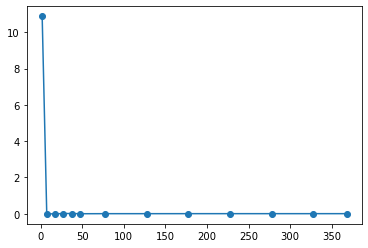

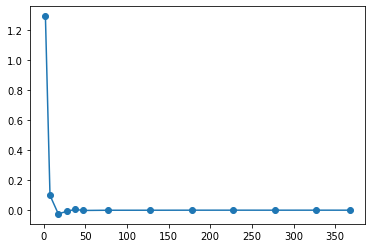

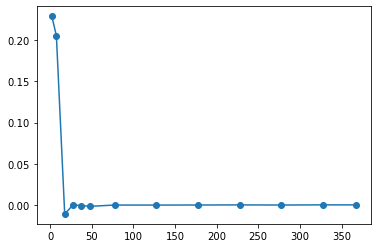

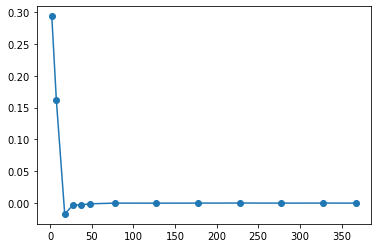

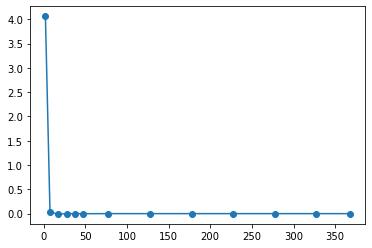

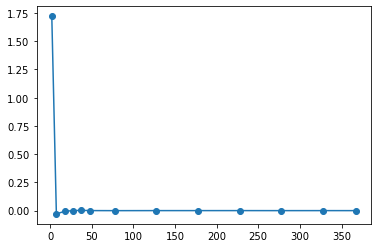

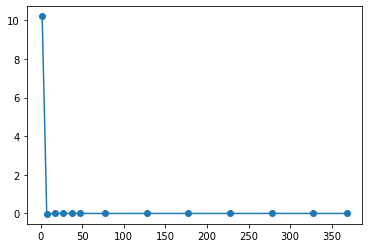

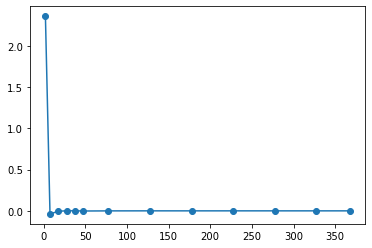

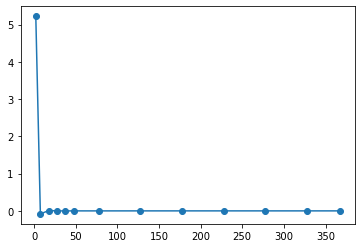

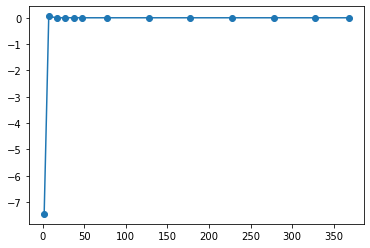

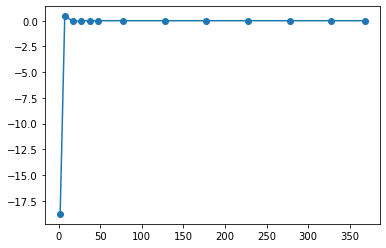

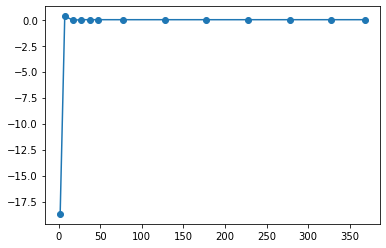

In [10]:
for cl in cls_fid:
    plt.figure()
    plt.plot(b.get_effective_ells(), cl, 'o-')

Create jackknife regions

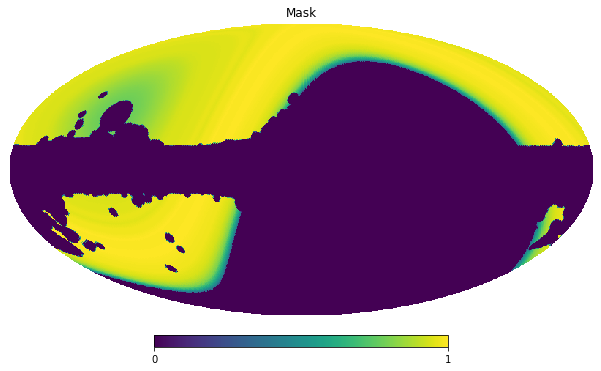

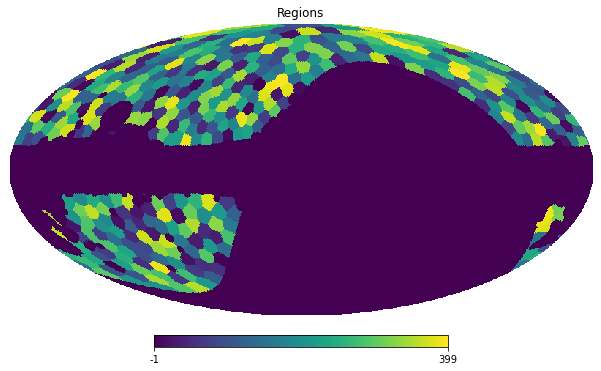

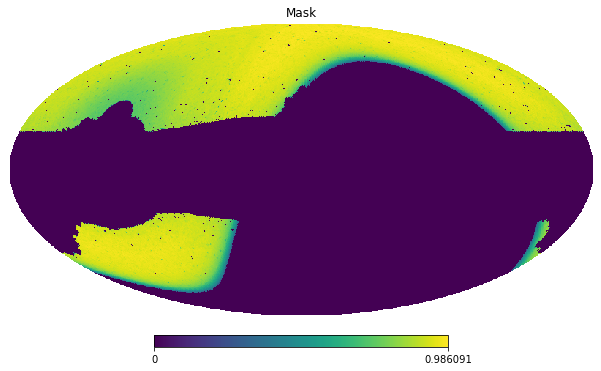

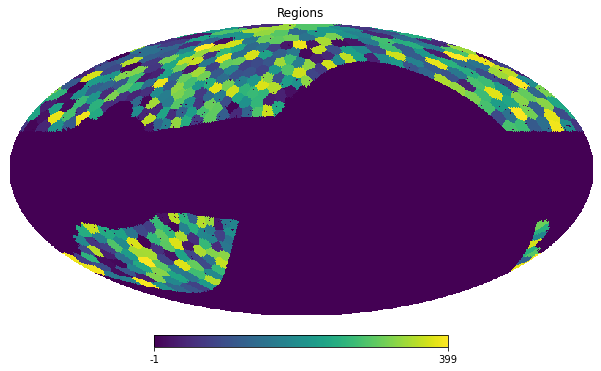

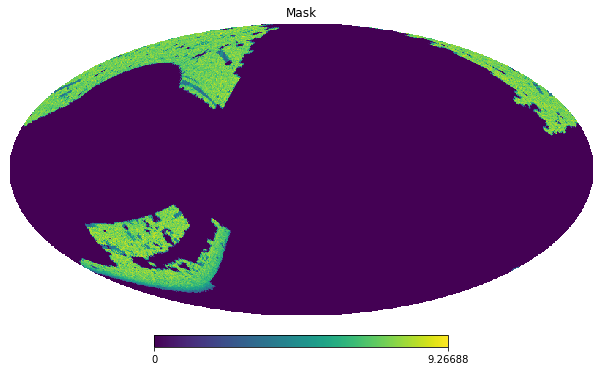

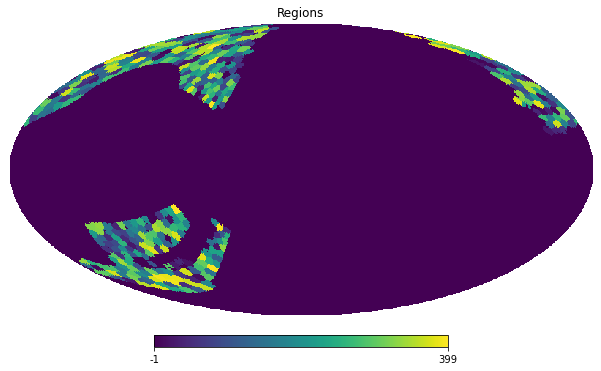

In [11]:
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample
import os


def get_regions(mask, n_regions, unassigned=hp.UNSEEN):
    """ Generates `n_regions` regions of roughly equal area
    for a given sky mask `mask`, assuming HEALPix "RING"
    ordering. Returns a HEALPix map where each pixel holds
    the index of the region it is assigned to. Unassigned
    pixels will take the `unassigned` value.
    """
    npix = len(mask)
    hp.npix2nside(npix)
    ipix = np.arange(npix)
    ra, dec = hp.pix2ang(nside, ipix, lonlat=True)
    goodpix = mask > 0
    km = kmeans_sample(np.array([ra[goodpix], dec[goodpix]]).T,
                       n_regions, maxiter=100, tol=1.0e-5,
                       verbose=False)
    map_ids = np.full(npix, unassigned)
    map_ids[ipix[goodpix]] = km.labels
    return map_ids


n_jk_regions = 400

# Find regions
if not os.path.isfile(f"jk_regions_{n_jk_regions}_ns128_2MPZ_WIxSC.npz"):
    jk_id_128_2MPZ_WIxSC = get_regions(mask_total[0], n_jk_regions, unassigned=-1)
    np.savez(f"jk_regions_{n_jk_regions}_ns128_2MPZ_WIxSC.npz", jks=jk_id_128_2MPZ_WIxSC)
jk_id_128_2MPZ_WIxSC = np.load(f"jk_regions_{n_jk_regions}_ns128_2MPZ_WIxSC.npz")['jks']
if not os.path.isfile(f"jk_regions_{n_jk_regions}_ns128_DELS.npz"):
    jk_id_128_DELS = get_regions(mask_total[6], n_jk_regions, unassigned=-1)
    np.savez(f"jk_regions_{n_jk_regions}_ns128_DELS.npz", jks=jk_id_128_DELS)
jk_id_128_DELS = np.load(f"jk_regions_{n_jk_regions}_ns128_DELS.npz")['jks']
if not os.path.isfile(f"jk_regions_{n_jk_regions}_ns128_QSO.npz"):
    jk_id_128_QSO = get_regions(mask_total[10], n_jk_regions, unassigned=-1)
    np.savez(f"jk_regions_{n_jk_regions}_ns128_QSO.npz", jks=jk_id_128_QSO)
jk_id_128_QSO = np.load(f"jk_regions_{n_jk_regions}_ns128_QSO.npz")['jks']

# Plot result
hp.mollview(mask_total[0], title='Mask')
hp.mollview(jk_id_128_2MPZ_WIxSC, title='Regions')
hp.mollview(mask_total[6], title='Mask')
hp.mollview(jk_id_128_DELS, title='Regions')
hp.mollview(mask_total[10], title='Mask')
hp.mollview(jk_id_128_QSO, title='Regions')

Loop over jackknives

In [12]:
cls_jk = []
for i in range(n_jk_regions):
    if i % 20 == 0:
        print(i)
    cls_jk_split = []
    mask_0 = mask_total[0].copy()
    mask_0[jk_id_128_2MPZ_WIxSC == i] = 0
    cls_jk_split += list(get_cls(mask_0, [0,1,2,3,4,5]))
    mask_6 = mask_total[6].copy()
    mask_6[jk_id_128_DELS == i] = 0
    cls_jk_split += list(get_cls(mask_6, [6,7,8,9]))
    mask_10 = mask_total[10].copy()
    mask_10[jk_id_128_QSO == i] = 0
    cls_jk_split += list(get_cls(mask_10, [10,11]))
    cls_jk.append(cls_jk_split)
cls_jk = np.array(cls_jk).squeeze()
print(cls_jk.shape)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
(400, 12, 13)


Compute jackknife covariance

In [13]:
nbins, nbpw = cls_fid.shape
cov_fid = n_jk_regions*np.cov(cls_jk.reshape([n_jk_regions, -1]).T).reshape([nbins, nbpw, nbins, nbpw])

Plot'em

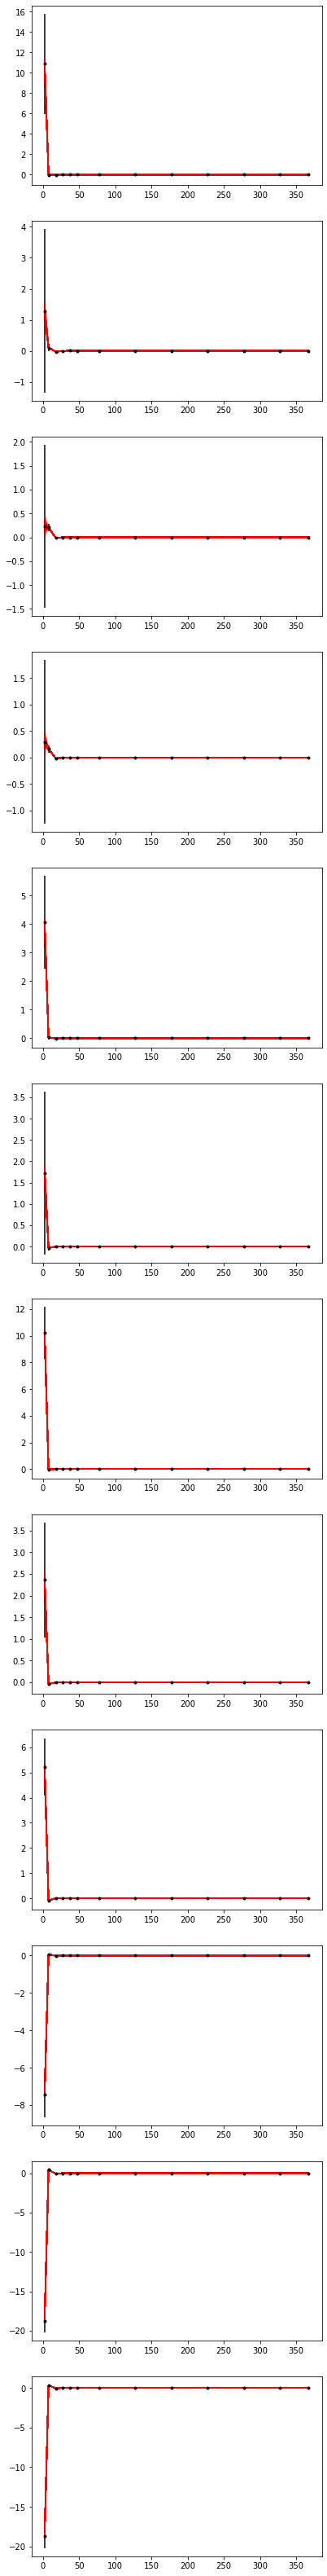

In [14]:
ls = b.get_effective_ells()
fig, axs = plt.subplots(nbins, figsize = (6.4, 4.8*nbins))
for i in range(nbins):
    cl = cls_fid[i]
    cov = cov_fid[i, :, i, :]
    axs[i].errorbar(ls, cl, yerr=np.sqrt(np.diag(cov)), fmt='k.')
    for j in range(n_jk_regions):
        axs[i].plot(ls, cls_jk[j, i], 'r-', alpha=0.05)
if map_energy:
    plt.savefig('GetFluxCls_energy.pdf')
else:
    plt.savefig('GetFluxCls_number.pdf')

Save into sacc format

In [15]:
import sacc

s = sacc.Sacc()
for i, (z, nz) in enumerate(zip(zs, dndzs)):
    s.add_tracer('NZ', f'LOWZ__{i}',
                quantity='galaxy_density', spin=0, z=z, nz=nz)
s.add_tracer('Map', 'IceCubeY10', quantity='generic',
             spin=0, ell=np.array([0, 1, 2]),
             beam=np.array([1, 1, 1]))
for i, cl in enumerate(cls_fid):
    s.add_ell_cl('cl_00', f'LOWZ__{i}', 'IceCubeY10', ls, cl)
s.add_covariance(cov_fid.reshape([nbins*nbpw, nbins*nbpw]))
if map_energy:
    s.save_fits('cl_flux_energy.fits', overwrite=True)
else:
    s.save_fits('cl_flux_number.fits', overwrite=True)